<h3>Tensorflow로 배우는<span class="tocSkip"></span></h3>
<h1>Word2Vec<span class="tocSkip"></span></h1>
<h2>(Skip-Gram model)<span class="tocSkip"></span></h2>

<br>
리소스: https://towardsdatascience.com/learn-word2vec-by-implementing-it-in-tensorflow-45641adaf2ac

# 초간단 Knowledge!

## Word2Vec 개요
    1. Word Embedding
    2. Word2Vec

### Word Embedding
    word embedding (단어 임베딩)이란 텍스트를 구성하는
    각 단어를 (주로 머신러닝을 위해) 수치화(벡터화)하는 작업이다.
    이에 기본적인 예는 BoW (Bag of Words)이다.
    여기서 이어 CBBOW (Continuous bow),
    Skip-Gram,
    그리고 CBOW, Skip-Gram 짬뽕:
    gensim 패키지에 속한 Word2Vec이다.

### Word2Vec
    - 위에 말했듯이 Word2Vec은 CBOW와 Skim-Gram에 짬뽕이다.
    - 이에 여러 작업이 추가되어 있다.
        a. hierarchial softmax
        b. negative sampling
    - Word2Vec은 구글사에서 제공되며,
    - 오픈소스여서 누구나 사용할 수 있다.
    - 2013년도에 Tomas Mikolov(와 다른 팀 멤버들)이 만들었다.
        - 논문: https://arxiv.org/pdf/1310.4546.pdf
    - shallow neural network이며, 3개 레이어를 사용한다.
        a. 1 input layer
        b. 1 hidden layer
        c. 1 output layer
    - word2vec의 특징:
        a. 지정 단어에 연관된 단어를 예측하는 식으로 학습
        b. output layer를 제거할 수 있음
        c. hidden layer로 지정 단어의 context를 뽑을 수 있다.

# 코딩!
    원래 Word2Vec은 Gensim library에서 호출해서
    아주 쉽게 사용할 수 있다.
    그러나 Word2Vec 모델의 원리를 알아낼려면
    간단히 코드를 사용해봤자 이해하기 어려우니,
    tensorflow를 사용하여 word2vec 기능들을 살펴본다.

## 필요한 library들 import

In [1]:
import numpy as np
import tensorflow as tf
from sklearn.manifold import TSNE
from sklearn import preprocessing
import matplotlib.pyplot as plt

## 학습 데이터

In [2]:
corpus_raw = "He is the king . The king is royal . She is the royal queen"

corpus_raw = corpus_raw.lower()

In [3]:
print(corpus_raw)

he is the king . the king is royal . she is the royal queen


### 데이터 전처리

#### 단어 추출

In [4]:
words = []

for word in corpus_raw.split():
    # 단어들만 추출
    if word != '.':
        words.append(word)
        
words = set(words)

#### 정제된 문장 추출

In [5]:
raw_sents = corpus_raw.split('.')

sents = []

for sent in raw_sents:
    sents.append(sent.split())

In [6]:
print(sents)

[['he', 'is', 'the', 'king'], ['the', 'king', 'is', 'royal'], ['she', 'is', 'the', 'royal', 'queen']]


## Skip-Gram 모델
    Skip-Gram 모델은 input 데이터가 (x, y)형태로,
    단어와 예측할 단어 pair(커플)로 학습한다.
    이러한 input 데이터가 만들어 지기 위해선,
    문장에서 지정 window (단어의 n개 앞,뒤) 사이즈로
    문장 단어 하나씩 그 주변의 단어들과 pairing 해준다.

![skipgram](https://user-images.githubusercontent.com/44990492/56113548-295b6000-5f99-11e9-93f0-a953eb67a797.png)

### 단어 pairing

In [7]:
data = []

# 여기선 단어 앞뒤 2개씩, min 2개 pair, max 4개 pair가 된다.
WINDOW_SIZE = 2

for sent in sents:
    for word_index, word in enumerate(sent):
        for nb_word in sent[\
            max(word_index - WINDOW_SIZE, 0) : \
            min(word_index + WINDOW_SIZE, len(sent)) + 1] :
                if nb_word != word:
                    data.append([word, nb_word])

In [8]:
print(data)

[['he', 'is'], ['he', 'the'], ['is', 'he'], ['is', 'the'], ['is', 'king'], ['the', 'he'], ['the', 'is'], ['the', 'king'], ['king', 'is'], ['king', 'the'], ['the', 'king'], ['the', 'is'], ['king', 'the'], ['king', 'is'], ['king', 'royal'], ['is', 'the'], ['is', 'king'], ['is', 'royal'], ['royal', 'king'], ['royal', 'is'], ['she', 'is'], ['she', 'the'], ['is', 'she'], ['is', 'the'], ['is', 'royal'], ['the', 'she'], ['the', 'is'], ['the', 'royal'], ['the', 'queen'], ['royal', 'is'], ['royal', 'the'], ['royal', 'queen'], ['queen', 'the'], ['queen', 'royal']]


### 데이터 numbering
    머신러닝 학습을 위해 단어를 숫자로 대체해야 된다.
    단어에 대한 인덱싱 처리한거라 생각하면 된다.

In [9]:
word2int = {}
int2word = {}

vocab_size = len(words)

for i, word in enumerate(words):
    word2int[word] = i
    int2word[i] = word

print(word2int)
print(int2word)

{'is': 0, 'king': 1, 'she': 2, 'the': 3, 'queen': 4, 'royal': 5, 'he': 6}
{0: 'is', 1: 'king', 2: 'she', 3: 'the', 4: 'queen', 5: 'royal', 6: 'he'}


### 1-to-N (one-hot) encoding
![identity](https://user-images.githubusercontent.com/44990492/56113597-4728c500-5f99-11e9-99ca-e1c66875ab2a.png)

#### look-up-table
    one-hot vector는 identity matrix의 역활을 한다.
    즉, 지정 매트릭스에 n 번째 행을 갖고옴으로,
    Neural Network에선 Weight 매트릭스에 n 번째
    행을 갖고 오는 역활을 한다.
    좀 더 정확히 말하자면,
    'he'라는 단어가 현재 0000001 로 벡터화 되어있다면,
    이를 학습된 Weight1(hidden layer)에 곱하면,
    Weight에 7 번째 줄이 뽑힌다.
    Weight[7] 줄은 'he'에 대한 단어의
    neighbor (context)들에 대한 거리들이 표현되어 있다.

In [10]:
def to_one_hot(data_point_index, vocab_size):
    temp = np.zeros(vocab_size)
    temp[data_point_index] = 1
    return temp

#### one-hot처리 동시에 x, y 데이터 구분

In [11]:
x_train = []
y_train = []

for data_word in data:
    x_train.append( to_one_hot( word2int[ data_word[0] ],
                              vocab_size))
    y_train.append( to_one_hot( word2int[ data_word[1] ],
                              vocab_size))
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)

In [12]:
print(x_train[:10])

[[0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]]


In [13]:
print(y_train[:10])

[[1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0.]]


### 데이터에 대한 정의
    보다시피, 'he'라는 단어가 [0,0,0,0,0,0,1]로 처리됬고,
    'he'의 동네친구 'is'와 'the'는 각 각
    0010000, 0000100 으로 바뀌었다.
    한 마디로,
    0000001 이란 데이터가 들어오면,
    0010000, 또는 0000100 이란 데이란 데이터가 예측되어야 된다.

## 3-layer Neural Network

In [14]:
tf.reset_default_graph()

# 1. INPUT LAYER
X = tf.placeholder(tf.float32, shape=(None, vocab_size))
Y = tf.placeholder(tf.float32, shape=(None, vocab_size))

# 2. HIDDEN LAYER
EMBEDDING_DIM = 5
# Embedding dimension:
# 제대로된 의미는 모르겠지만
# 대강 각 단어의 특징을 5개 정도 잡는다고 생각하면 될듯.
# 너무 적으면 안 되고 너무 많으면 안된다.

W1 = tf.Variable(tf.random_normal([vocab_size, EMBEDDING_DIM]))
b1 = tf.Variable(tf.random_normal([EMBEDDING_DIM]))

# Hidden Representation
# 이 모델에 사용되는 Hypothesis는
# 따로 사용될 수 있는 
# 숨어 있는 용도가 있다.
H = tf.add(tf.matmul(X, W1), b1)

# 3. OUTPUT LAYER
W2 = tf.Variable(tf.random_normal([EMBEDDING_DIM, vocab_size]))
b2 = tf.Variable(tf.random_normal([vocab_size]))

# activation function => softmax 사용
prediction = tf.nn.softmax(tf.add(tf.matmul(H, W2), b2))

# input_one_hot => embedded repr. => predicted_neighbor_prob
# predicted_prob will be compared against a one hot vector

sess = tf.Session()

sess.run(tf.global_variables_initializer())

# cost function => cross entropy (log loss)
cross_entropy_loss = tf.reduce_mean(
    -tf.reduce_sum(Y * tf.log(prediction), 
                  reduction_indices=[1]))


optimizer = tf.train.GradientDescentOptimizer(0.1)

model_train = optimizer.minimize(cross_entropy_loss)

# 학습 반복수
epoch = 10000

for step in range(epoch):
    sess.run(model_train, feed_dict={X: x_train, Y: y_train})
    
    if step%1000==0:
        loss = sess.run(cross_entropy_loss, 
                        feed_dict={X: x_train, Y: y_train})
        print("loss is : {}".format(loss) )

loss is : 3.305218458175659
loss is : 1.3281892538070679
loss is : 1.3235028982162476
loss is : 1.3222616910934448
loss is : 1.321708083152771
loss is : 1.3213995695114136
loss is : 1.321204423904419
loss is : 1.3210707902908325
loss is : 1.3209737539291382
loss is : 1.3209004402160645


### Hidden Representation
    이 모델 자체는 지정 단어에 n-gram 근접한 단어를
    예측하는 식으로 학습이 되어 있지만,
    이 예측모델을 사용하는 대신에
    학습하면서 생기는 첫 번쨰 layer의
    W1와 b1 값이다.
    W1,b1은 위에 one-hot 처리 사용 (look-up-table)을 사용하여
    지정 단어에 대한 학습된 벡터를 찾을 수 가 있다.

In [15]:
print(sess.run(W1))

[[ 0.16884391  0.47522554  1.7791299   2.1045978   1.7259084 ]
 [ 1.3524605  -0.9047998   0.16236609 -0.30971235 -0.39247093]
 [-0.47699308 -0.194042   -0.43534783 -1.0635788  -0.09963643]
 [ 1.6984836   1.1369572  -1.6472584   1.4050508   0.9246166 ]
 [ 1.2601703  -1.5514985   1.6991419   0.49853742  0.26527128]
 [-0.10860179  2.4968026  -0.12641595 -0.6618412   0.5468745 ]
 [ 0.3452465  -0.30957833 -0.03553431 -1.8872234  -0.08141606]]


In [16]:
print(sess.run(b1))

[ 1.2462664   0.6626038   0.87485343 -0.04988753 -2.7971547 ]


In [17]:
vectors = sess.run(W1 + b1)

In [18]:
print(vectors)

[[ 1.4151102   1.1378293   2.6539834   2.0547104  -1.0712463 ]
 [ 2.5987267  -0.24219602  1.0372195  -0.3595999  -3.1896255 ]
 [ 0.7692733   0.4685618   0.4395056  -1.1134664  -2.896791  ]
 [ 2.9447498   1.799561   -0.77240497  1.3551632  -1.8725381 ]
 [ 2.5064368  -0.88889474  2.5739954   0.44864988 -2.5318835 ]
 [ 1.1376646   3.1594064   0.74843746 -0.71172875 -2.2502801 ]
 [ 1.5915129   0.35302547  0.8393191  -1.9371109  -2.8785708 ]]


In [19]:
print(vectors[ word2int['queen'] ])

[ 2.5064368  -0.88889474  2.5739954   0.44864988 -2.5318835 ]


## 근접 단어 찾기

### Euclidean Distance (유클리드 거리)
    피타고라스 정리를 기반으로한 유클리드 거리이다.
    두 점 사이의 거리를 계산할 때 흔히 사용되는 방법이다.
    특히 자연어처리에 있어 두 벡터 사이의 거리를 계산,
    즉, 지정 단어와 근접한 단어의 거리를 계산하는데
    자주 사용된다.

#### 유클리드 거리 그림
![Euclidean_distance](https://user-images.githubusercontent.com/44990492/56113606-527bf080-5f99-11e9-8f24-4bcf05b34f06.png)

#### 유클리드 거리 수식
![Euclidean_distance_function](https://user-images.githubusercontent.com/44990492/56113615-5ad42b80-5f99-11e9-9075-e0c5dc66ee46.PNG)

#### numpy로 수식 구현

In [20]:
def euclidean_dist(vec1, vec2):
    
    return np.sqrt(np.sum(np.square(vec1-vec2)))

### 근접 단어 검색 함수 코딩

In [21]:
def find_closest(word_index, vectors):
    min_dist = 10000 # to act like positive infinity?
    min_index = -1
    
    # input 단어에 대한 벡터값
    query_vector = vectors[word_index]
    
    # 각 벡터에 대한 index와 값들을 갖고와서,
    for index, vector in enumerate(vectors):
        # input단어 벡터와 각 벡터와의 거리가,
        # (근접거리:"무한"보다는 적고,)
        # 전에 적용된 근접거리 보다 적고,
        # 두 벡터가 똑같은게 아니면,
        if euclidean_dist(vector, query_vector) < min_dist \
        and not np.array_equal(vector, query_vector):
            # min_dist (근접거리) 새로 적용
            min_dist = euclidean_dist(vector, query_vector)
            # 현재 최소근접단어에 대한 인덱스 적용
            min_index = index
            
    # 위에 방식으로 하나하나 근접거리를 비교하고 나면
    # 최소근접거리의 단어 인덱스가 나온다.
    return min_index

#### 학습한 결과
    밑에 보다시피 위 학습모델은
    king은 queen과 근접하고,
    queen은 king과 근접하고,
    she는 he와 근접하다는 것을 배웠다.

In [22]:
for w in words:    
    print( w, int2word[ find_closest( word2int[w], vectors ) ] )

is queen
king queen
she he
the royal
queen king
royal she
he she


## 그래프로 확인해보기

### 디멘션 줄여주는 TSNE

In [23]:
model = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
vectors_2d = model.fit_transform(vectors)

### 벡터값 Normalize

In [24]:
normalizer = preprocessing.Normalizer()
vectors_2d = normalizer.fit_transform(vectors, '12')

### Matplotlib으로 plot

is: (0.3570253849029541,0.28706875443458557)
is  =>  queen

king: (0.6093035340309143,-0.056785840541124344)
king  =>  queen

she: (0.23588350415229797,0.14367586374282837)
she  =>  he

the: (0.6970052123069763,0.4259456396102905)
the  =>  royal

queen: (0.5561690330505371,-0.19724243879318237)
queen  =>  king

royal: (0.27268245816230774,0.7572659850120544)
royal  =>  she

he: (0.4055476188659668,0.0899575725197792)
he  =>  she



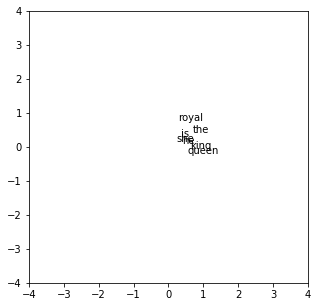

In [25]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
# fig, ax = plt.subplots()

for w in words:
    print("{}: ({},{})".format(w, 
                               vectors_2d[word2int[w]][0], 
                               vectors_2d[word2int[w]][1] ))
    
    print( w, " => ",int2word[ find_closest( word2int[w], vectors_2d ) ] )
    
    print()
    
    ax.annotate(w, 
        (vectors_2d[word2int[w]][0],vectors_2d[word2int[w]][1]) )
    
ax.set_ylim(-4,4)
ax.set_xlim(-4,4)

plt.show()

# 추가 노트
    밑에 보다시피 똑같은 모델을 여러번 돌려본 결과,
    학습이 일정하게 되어 있지 않다.
    물론 Weight와 bias값이 현재 random_normal로 되어있어
    이러한 현상은 자주 볼 수 있다.
    하지만 word2vec 모델 자체가 원래
    학습데이터가 많아야 학습이 잘 되는 모델이다.
    25,000 문장의 샘플 데이터를 사용했어도,
    기본 BoW 모델보다 정확성이 훨씬 높거나 훨씬 낮지도 않다.
    여기에 이어 negative sampling, hierarchial softmax도
    적용해야 그나마 제대로된 짜가 word2vec이 나온다.

model_1 결과 그래프
![model_1](https://user-images.githubusercontent.com/44990492/56113175-0a100300-5f98-11e9-9d1c-ea6849a5cb5d.png)

model_2 결과 그래프
![model_2](https://user-images.githubusercontent.com/44990492/56113657-6f182880-5f99-11e9-93d1-8ed89c0c7970.png)

model_3 결과 그래프
![model_3](https://user-images.githubusercontent.com/44990492/56113664-74757300-5f99-11e9-837b-4c9f617f28bc.png)

## CBOW
    Word2Vec은 원래 Skip-Gram (중심단어로 주변단어 찾기) 모델과,
    CBOW (주변단어로 중심단어 찾기) 모델로 구분된다.
    CBOW 모델로 구현하기 위해선,
    현재 학습된 모델에서 input을 주변단어로 넣으면 된다.

In [93]:
def find_center(context):
    context_hotone = np.zeros(shape=(1,vocab_size))
    # 총 단어수 7개보다 적으면,
    if len(context) < vocab_size:
        # context에 있는 단어가
        for word in context:
            # vocab에 있는 단어가 맞다면,
            if word in words:
                # 단어에 대한 hotone encoding을 추출하고
                word_hotone = np.unique(x_train, axis=0)[::-1][word2int[word]]
                # 단어 hotone encoding들을 합친다
                context_hotone = context_hotone + word_hotone
            else:
                print("Word is not in vocabulary")
                return
    else:
        print("Context exceeds the size of the vocabulary")
        return
    
    # 합쳐진 context hotone를 사용해서 예측
    # 원래 모델 자체가 단어 주변에 있는 단어를 예측하는 모델이니,
    # 여러 단어들에 공통적으로 주변에 있는 단어를 찾게 된다.
    probs = sess.run(prediction, feed_dict={X: context_hotone})
    # 예측할 단어 리스트에서 context 단어를 제외
    for word in context:
        if word in int2word.values():
            # 일단 제외방식을 확률을 -로 바꾸는걸로 한다.
            probs[0][word2int[word]] = -probs[0][word2int[word]]
    # 확률이 제일 높은거의 인덱스 가져오기
    center_idx = np.argmax(probs)
    # 인덱스 look up해서 단어 가져오기
    result = int2word[center_idx]
    
    return result, probs

In [107]:
corpus_raw

'he is the king . the king is royal . she is the royal queen'

In [116]:
word2int

{'is': 0, 'king': 1, 'she': 2, 'the': 3, 'queen': 4, 'royal': 5, 'he': 6}

In [134]:
# 위에 문장을 확인해보면 "she is the royal queen"이다.
# 'royal'을 뺀 문장, 'she is the ___ queen'의 값을 넣어주면
# 이 사이의 단어를 알려준다.
context = ['she','is','the','queen']
result, probs = find_center(context)
print("{} : {}".format(context, result))

['she', 'is', 'the', 'queen'] : royal


In [135]:
# 확률 벡터를 확인하여 확률이 높은 단어들을 확인해본다.
# 보다시피 royal이 제일 확률이 높았고,
# 그 다음으로 'he'가 높았다.
# 그 이유는 'is','the' 둘다 'he'와 제법 근접한 단어들이기 때문이다.
probs

array([[-0.00000011,  0.01272334, -0.00247079, -0.0000056 , -0.00000007,
         0.5790665 ,  0.4057336 ]], dtype=float32)

In [38]:
for w in words:    
    print( w, int2word[ find_closest( word2int[w], vectors ) ] )

is queen
king queen
she he
the royal
queen king
royal she
he she
